Using a dataset of your choice, select an outcome variable and then pick four or five other variables (one to two categorical, three to four continuous) to act as the basis for features. Explore the variables using the univariate and bivariate methods you've learned so far. 

Next, based on what you learned via your data exploration, create ten new features. Explain the reasoning behind each one.

Finally, use filtering methods to select the five best features and justify your choices.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
%matplotlib inline

from GDELT_utils import GDELT_columns, usecols, dtype_dict, \
                        cameo_dict, map_cameo_to_text, \
                        state_dict, mem_usage, state_heat_map
        
data_2016 = ["./20161101.export.CSV.pkl" "./20161111.export.CSV.pkl" "./20161121.export.CSV.pkl"
            "./20161102.export.CSV.pkl" "./20161112.export.CSV.pkl" "./20161122.export.CSV.pkl"
            "./20161103.export.CSV.pkl" "./20161113.export.CSV.pkl" "./20161123.export.CSV.pkl"
            "./20161104.export.CSV.pkl" "./20161114.export.CSV.pkl" "./20161124.export.CSV.pkl"
            "./20161105.export.CSV.pkl" "./20161115.export.CSV.pkl" "./20161125.export.CSV.pkl"
            "./20161106.export.CSV.pkl" "./20161116.export.CSV.pkl" "./20161126.export.CSV.pkl"
            "./20161107.export.CSV.pkl" "./20161117.export.CSV.pkl" "./20161127.export.CSV.pkl"
            "./20161108.export.CSV.pkl" "./20161118.export.CSV.pkl" "./20161128.export.CSV.pkl"
            "./20161109.export.CSV.pkl" "./20161119.export.CSV.pkl" "./20161129.export.CSV.pkl"
            "./20161110.export.CSV.pkl" "./20161120.export.CSV.pkl" "./20161130.export.CSV.pkl"]

In [2]:
interest = ["GLOBALEVENTID", "SQLDATE",
            "AvgTone", "QuadClass", "GoldsteinScale",
            "NumMentions", "IsRootEvent", "EventRootCode",
            #"EventBaseCode", "EventCode",
            #"Actor1Code", "Actor2Code",
            "Actor1CountryCode", "Actor2CountryCode",
            "Actor1KnownGroupCode", "Actor2KnownGroupCode",
            #"Actor1EthnicCode", "Actor2EthnicCode",
            "Actor1Religion1Code", "Actor2Religion1Code",
            #"Actor1Religion2Code", "Actor2Religion2Code",
            "Actor1Type1Code", "Actor2Type1Code",
            #"Actor1Type2Code", "Actor2Type2Code",
            #"Actor1Type3Code", "Actor2Type3Code",
            "Actor1Geo_CountryCode", "Actor2Geo_CountryCode", "ActionGeo_CountryCode",
            #"Actor1Geo_ADM1Code", "Actor2Geo_ADM1Code", "ActionGeo_ADM1Code"
           ]

# When creating categorical toggles should I worry about:
# Unknown country versus definitely not this one
# I.e. we might not know a country at all
# should this be different for a model than knowing it's not all of these

# plotting big data

In [3]:
df_2016 = pd.read_csv(data_2016, sep='\t', names=GDELT_columns, 
                        usecols=interest, dtype=dtype_dict, 
                        parse_dates=['SQLDATE'])

df_2016_us = df_2016.loc[(df_2016['ActionGeo_CountryCode'] == 'US') |\
                         (df_2016['Actor1Geo_CountryCode'] == 'US') |\
                         (df_2016['Actor2Geo_CountryCode'] == 'US'),:].copy()

election_day_2016 = np.datetime64('2016-11-08')
df_2016_usel = df_2016_us.loc[df_2016_us['SQLDATE'] == election_day_2016,:] \
                         .copy()

In [13]:
len(df_2016)

232926

GLOBALEVENTID
SQLDATE
Actor1CountryCode
Actor1KnownGroupCode
Actor1Religion1Code
Actor1Type1Code
Actor2CountryCode
Actor2KnownGroupCode
Actor2Religion1Code
Actor2Type1Code
IsRootEvent
EventRootCode
QuadClass
GoldsteinScale
NumMentions
AvgTone
Actor1Geo_CountryCode
Actor2Geo_CountryCode


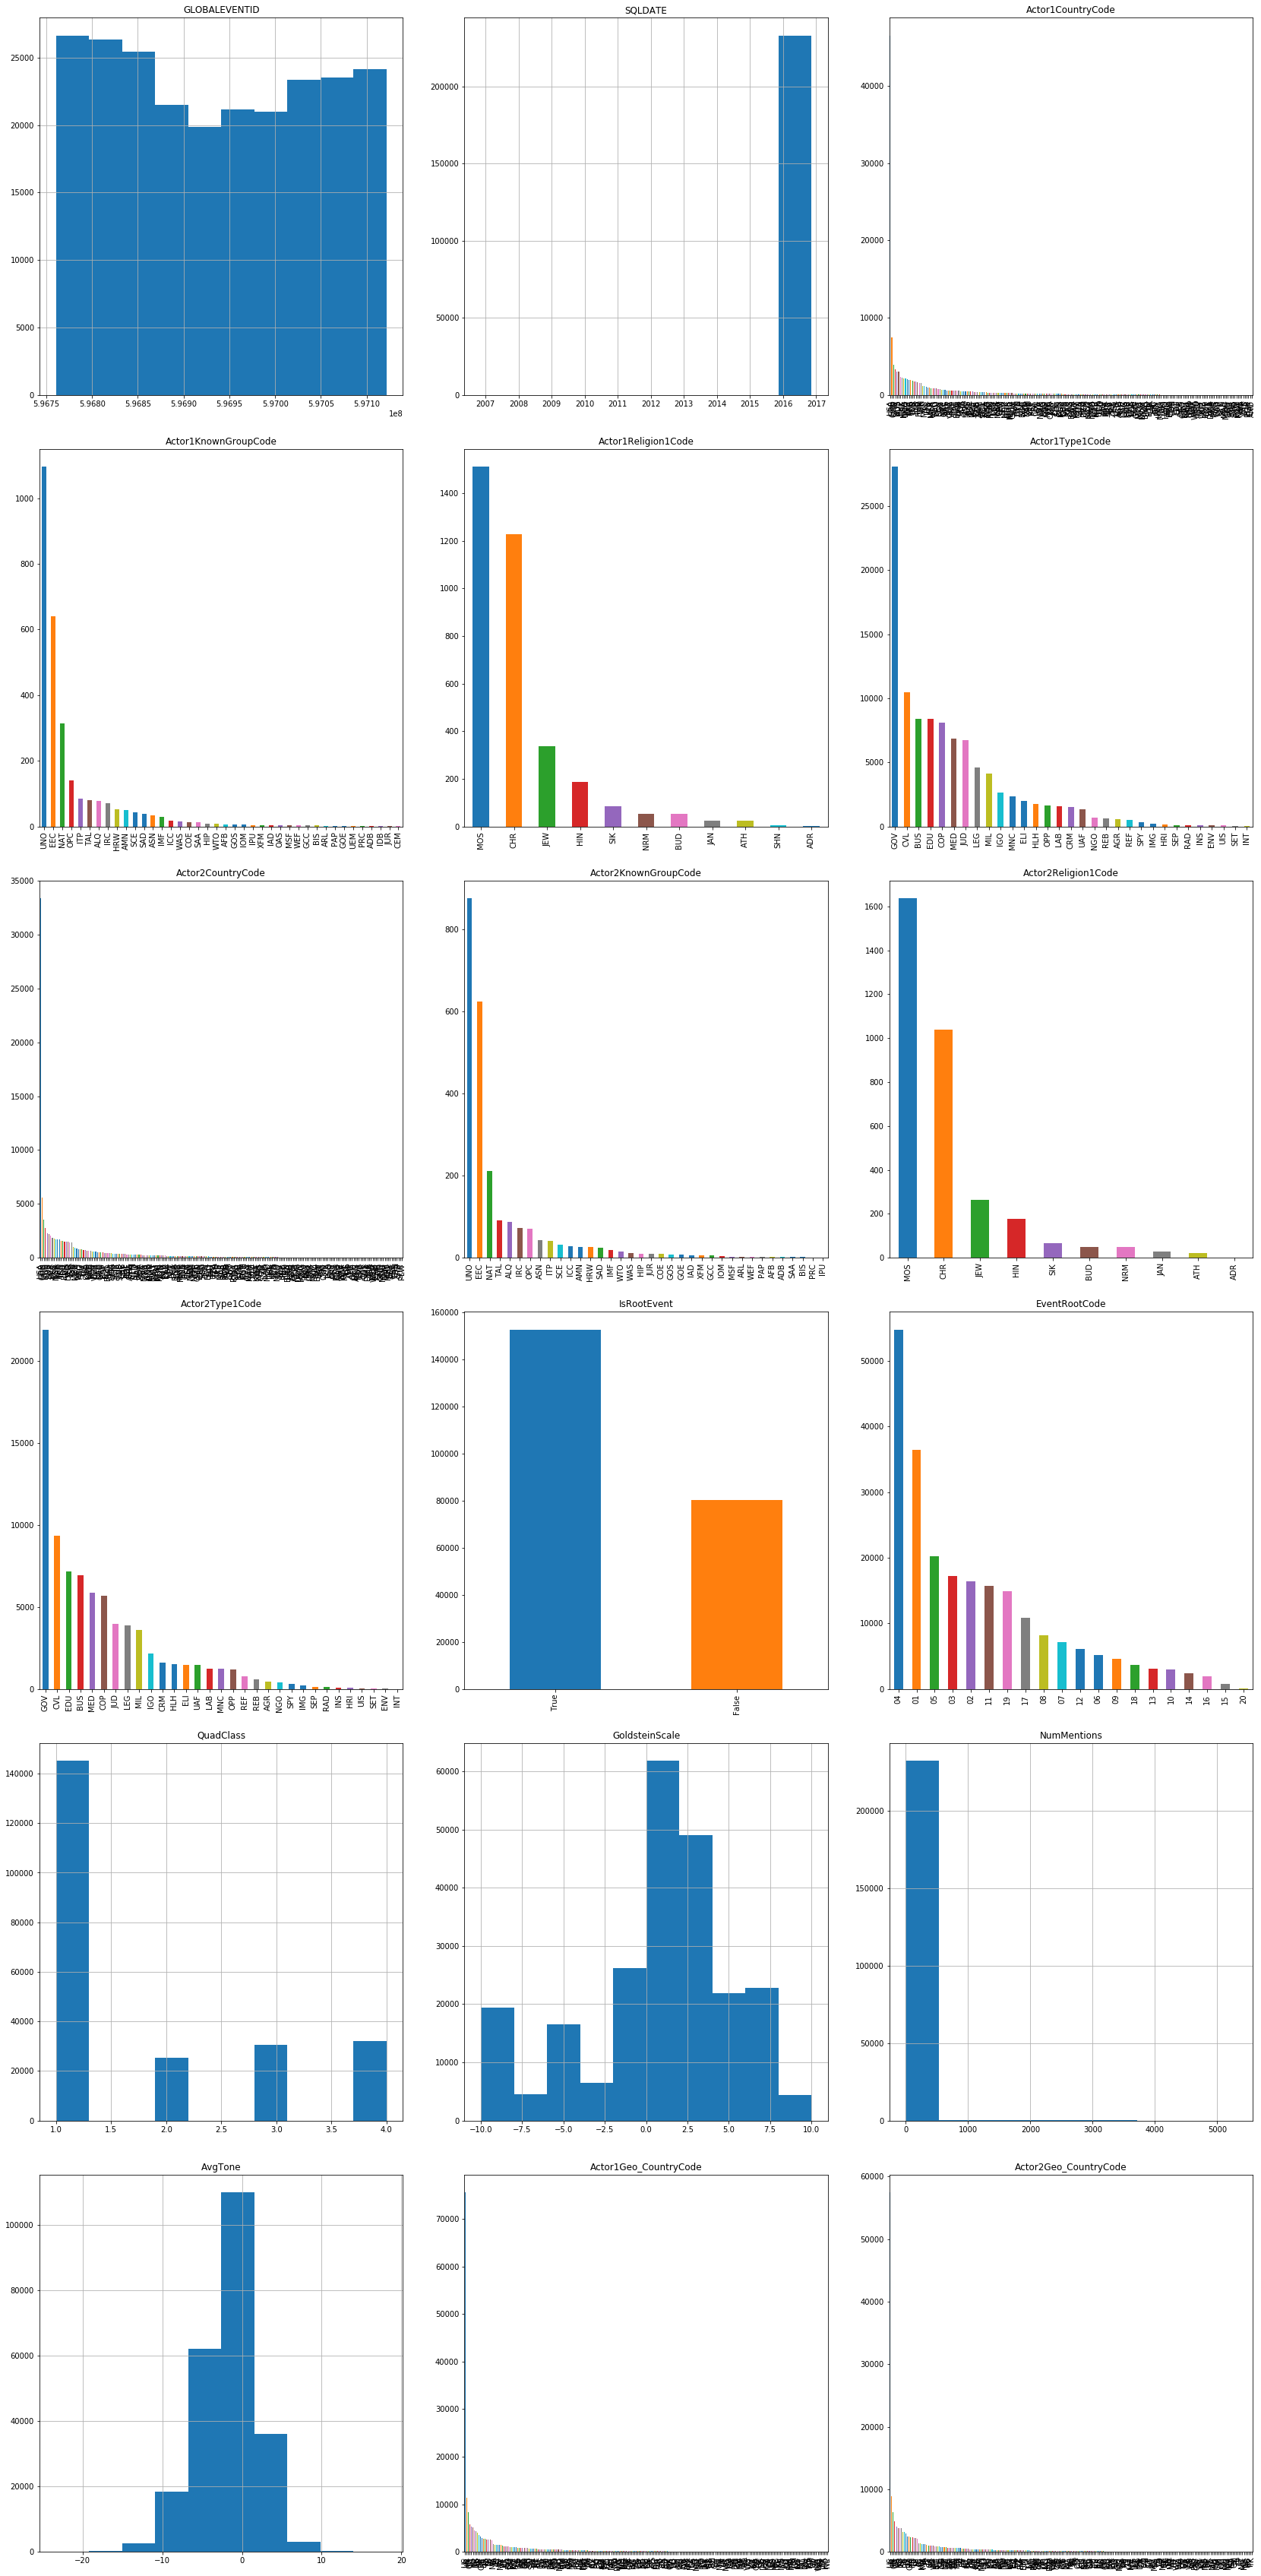

In [12]:
# https://stackoverflow.com/questions/39646070/pandas-histogram-plot-histogram-for-each-column-as-subplot-of-a-big-figure
fig, axes = plt.subplots(len(df_2016.columns)//3, 3, figsize=(24, 48))
plt.tight_layout(pad=5, w_pad=5, h_pad=5)
for col, axis in zip(df_2016.columns, axes.flatten()):
    no_na = df_2016[col].dropna().copy()
    enough_data = no_na.value_counts() \
                    [(no_na.value_counts()/ \
                        no_na.value_counts().sum()) > 0.005]
    df_2016_graph = df_2016[col]
    dtype_name = df_2016_graph.dtype.name
    axis.set_title(col)
    print(col)
    if dtype_name == 'category' or dtype_name == 'bool' \
            or dtype_name == 'object':
        if dtype_name == 'category':
            df_2016_graph.cat.remove_unused_categories() \
                        .value_counts().plot(kind="bar", ax=axis)
        else:
            df_2016_graph.value_counts().plot(kind="bar", ax=axis)
    else:
        df_2016_graph.hist(ax=axis)

In [14]:
df_2016.corr()

,GLOBALEVENTID,IsRootEvent,QuadClass,GoldsteinScale,NumMentions,AvgTone
GLOBALEVENTID,1.000000,-0.028475,0.001500,-0.000713,-0.097375,0.032017
IsRootEvent,-0.028475,1.000000,-0.000711,-0.007874,0.052631,0.058676
QuadClass,0.001500,-0.000711,1.000000,-0.776785,0.003929,-0.358329
GoldsteinScale,-0.000713,-0.007874,-0.776785,1.000000,-0.009609,0.347098
NumMentions,-0.097375,0.052631,0.003929,-0.009609,1.000000,-0.024080
AvgTone,0.032017,0.058676,-0.358329,0.347098,-0.024080,1.000000


In [17]:
df_2016.groupby('QuadClass').mean()

,GLOBALEVENTID,IsRootEvent,GoldsteinScale,NumMentions,AvgTone
QuadClass,,,,,
1,5.969370e+08,0.658704,2.404440,14.458202,-0.832808
2,5.969375e+08,0.644958,5.081303,14.442366,-1.518582
3,5.969383e+08,0.628573,-3.411813,14.519820,-2.801533
4,5.969369e+08,0.674118,-7.932970,15.466996,-4.565053


In [18]:
df_2016.groupby('QuadClass').corr()

AvgTone  GLOBALEVENTID  GoldsteinScale  \
QuadClass                                                           
1         AvgTone         1.000000       0.033987        0.156164   
          GLOBALEVENTID   0.033987       1.000000       -0.001293   
          GoldsteinScale  0.156164      -0.001293        1.000000   
          IsRootEvent     0.112291      -0.024896       -0.007768   
          NumMentions    -0.020077      -0.099280       -0.012260   
2         AvgTone         1.000000       0.038723        0.178519   
          GLOBALEVENTID   0.038723       1.000000        0.011707   
          GoldsteinScale  0.178519       0.011707        1.000000   
          IsRootEvent     0.066110      -0.032962       -0.048742   
          NumMentions    -0.029275      -0.085222       -0.029165   
3         AvgTone         1.000000       0.023740       -0.035017   
          GLOBALEVENTID   0.023740       1.000000        0.001046   
          GoldsteinScale -0.035017       0.001046        1.000000   
          IsRootEvent    -0.003172      -0.029826        0.022571   
          NumMentions    -0.023391      -0.106540        0.012881   
4         AvgTone         1.000000       0.044353       -0.011546   
          GLOBALEVENTID   0.044353       1.000000       -0.011602   
          GoldsteinScale -0.011546      -0.011602        1.000000   
          IsRootEvent    -0.070052      -0.039256        0.021193   
          NumMentions    -0.039425      -0.092159       -0.009583   

                          IsRootEvent  NumMentions  
QuadClass                                           
1         AvgTone            0.112291    -0.020077  
          GLOBALEVENTID     -0.024896    -0.099280  
          GoldsteinScale    -0.007768    -0.012260  
          IsRootEvent        1.000000     0.054589  
          NumMentions        0.054589     1.000000  
2         AvgTone            0.066110    -0.029275  
          GLOBALEVENTID     -0.032962    -0.085222  
          GoldsteinScale    -0.048742    -0.029165  
          IsRootEvent        1.000000     0.032057  
          NumMentions        0.032057     1.000000  
3         AvgTone           -0.003172    -0.023391  
          GLOBALEVENTID     -0.029826    -0.106540  
          GoldsteinScale     0.022571     0.012881  
          IsRootEvent        1.000000     0.059645  
          NumMentions        0.059645     1.000000  
4         AvgTone           -0.070052    -0.039425  
          GLOBALEVENTID     -0.039256    -0.092159  
          GoldsteinScale     0.021193    -0.009583  
          IsRootEvent        1.000000     0.054470  
          NumMentions        0.054470     1.000000

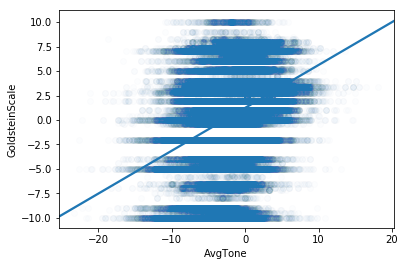

In [23]:
sns.regplot("AvgTone", "GoldsteinScale", 
            data=df_2016, scatter_kws={"alpha": .01})

In [37]:
df_2016['Conflict'] = df_2016['QuadClass'] > 2

In [40]:
df_2016['Conflict'].value_counts()

False    170319
True      62607
Name: Conflict, dtype: int64

In [33]:
df_2016['Violence'] = df_2016['QuadClass'] == 4

In [41]:
df_2016['Violence'].value_counts()

False    200718
True      32208
Name: Violence, dtype: int64

In [24]:
df_2016['GoldsteinTone'] = df_2016['GoldsteinScale'] + df_2016['AvgTone']

In [42]:
df_2016.groupby('QuadClass').mean()

,GLOBALEVENTID,IsRootEvent,GoldsteinScale,NumMentions,AvgTone,GoldsteinTone,Conflict,Violence
QuadClass,,,,,,,,
1,5.969370e+08,0.658704,2.404440,14.458202,-0.832808,1.571632,0.0,0.0
2,5.969375e+08,0.644958,5.081303,14.442366,-1.518582,3.562721,0.0,0.0
3,5.969383e+08,0.628573,-3.411813,14.519820,-2.801533,-6.212436,1.0,0.0
4,5.969369e+08,0.674118,-7.932970,15.466996,-4.565053,-12.498023,1.0,1.0


In [29]:
from scipy.stats import f_oneway

In [ ]:

f_oneway()